## Suggested Solution of Homework 1 of STAT3612
### _Prepared by Dr. Gilbert Lui_

In [1]:
import numpy as np
import statsmodels.api as sm
import pandas as pd
from datetime import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
%matplotlib inline

price = pd.read_csv("bitcoin.csv", 
                    header=None, 
                    names=['date', 'price'])
x = price.index.values
x.shape = (x.shape[0],1)
y = price.price.values
y.shape = (y.shape[0],1)
dt = [datetime.strptime(price.date[j], '%Y-%m-%d %H:%M:%S').date() for j in range(price.date.shape[0])]

## Step 1. Gaussian Kernel Smoothing by `statsmodels`

To perform Gaussian kernel smoothing which in fact is kernel regression, we can use the `KernelReg()` function in the package `statsmodels`. An important factor in this kernel smoothing problem is the calculation of bandwdith. Since the provided data is the time series data, the cross-validation method is not appropriate to determine the bandwidth. Thus, alternative approaches are considered here.

In [2]:
from statsmodels.nonparametric.kernel_regression import KernelReg
from scipy.optimize import minimize

**Method 1: Determination of bandwidth by non-linear optimization algorithm**

Bandwidth = 0.012130030538187045


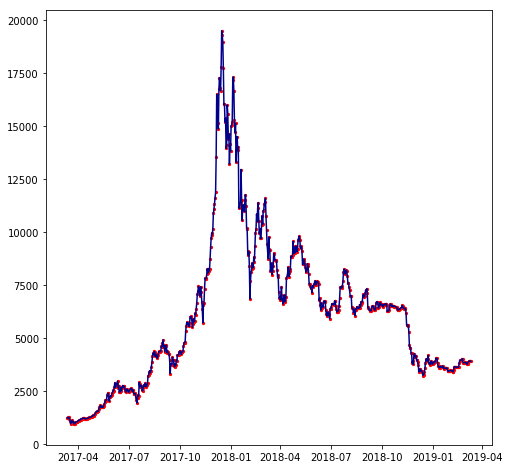

In [3]:
x0 = -7
def sse(h):
    kr = KernelReg(y, x, var_type='c', reg_type='lc', bw=np.array([np.exp(h)]))
    ypred, _ = kr.fit(x)
    return(np.sum((y-ypred)**2))

res = minimize(sse, x0, method='Powell', options={'ftol': 1e-30})
print("Bandwidth =", np.exp(res.x))
kr = KernelReg(y, x, var_type='c', reg_type='lc', bw=np.array([np.exp(res.x)]))
y_pred1, _ = kr.fit(x)

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(dt, y_pred1, "darkblue")
ax.scatter(dt, y, color='red',s=5)
ax.format_xdata = mdates.DateFormatter('%Y-%m')

**Method 2: Determination of bandwidth by AIC in the `KernelReg()` function**

Bandwidth = [0.09993181]


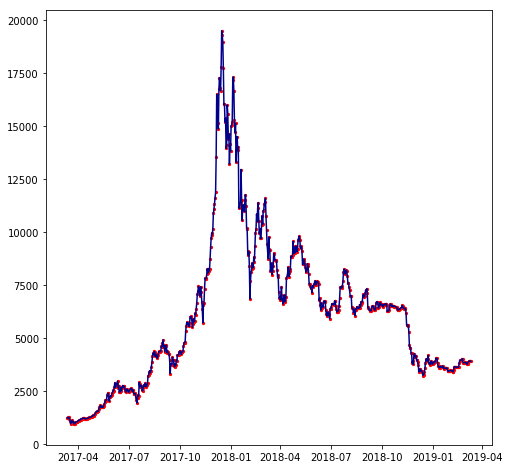

In [4]:
kr = KernelReg(y, x, var_type='c', reg_type='lc', bw="aic")
print("Bandwidth =", kr.bw)
y_pred2, _ = kr.fit(x)

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(dt, y_pred2, "darkblue")
ax.scatter(dt, y, color='red',s=5)
ax.format_xdata = mdates.DateFormatter('%Y-%m')

## Step 2. Linear Regression Fitting

SSE =  8746261898.9216
R-Squared =  0.0356
F-Statistic =  26.8998


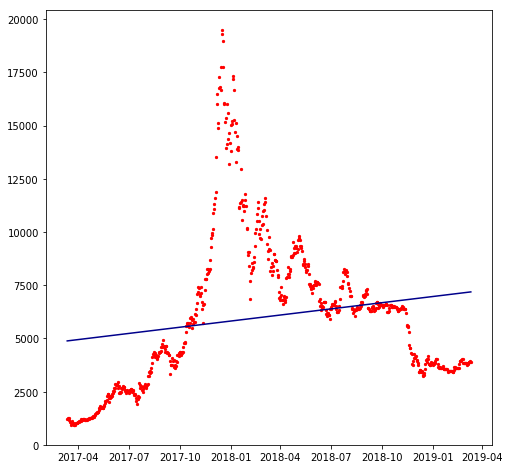

In [5]:
xnew = sm.add_constant(x)
model = sm.OLS(y, xnew).fit()
yhat = model.predict(xnew)
print("SSE = ", np.round(model.centered_tss - model.ess,4))
print("R-Squared = ", np.round(model.rsquared,4))
print("F-Statistic = ", np.round(model.fvalue,4))

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(dt, yhat, "darkblue")
ax.scatter(dt, y, color='red', s=5)
ax.format_xdata = mdates.DateFormatter('%Y-%m')

## Step 3. Regression with Piecewise Linear Splines (1 Knot)

SSE =  2369206548.8971
R-Squared =  0.7388
F-Statistic =  1027.9958


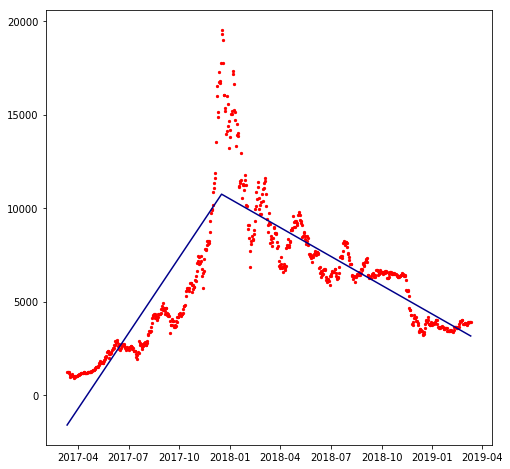

In [6]:
def PieceLinearSpline(x, tau):
    xphi = [min(max(x1-min(x), 0), tau[0]-min(x)) for x1 in x]
    for k in range(1,len(tau)):
        tmp = [min(max(x1-tau[k-1], 0), tau[k]-tau[k-1]) for x1 in x]
        xphi = np.column_stack((xphi, tmp))
    xphi = np.column_stack((xphi, [max(x1-tau[len(tau)-1], 0) for x1 in x]))
    return xphi

tau = [279]

xphi = PieceLinearSpline(x, tau)
xnew = sm.add_constant(xphi)
model = sm.OLS(y, xnew).fit()
yhat = model.predict(xnew)
print("SSE = ", np.round(model.centered_tss - model.ess,4))
print("R-Squared = ", np.round(model.rsquared,4))
print("F-Statistic = ", np.round(model.fvalue,4))

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(dt, yhat, "darkblue")
ax.scatter(dt, y, color='red',s=5)
ax.format_xdata = mdates.DateFormatter('%Y-%m')

## Step 4. Regression with Piecewise Linear Splines (3 Knots)

SSE =  501457300.4902
R-Squared =  0.9447
F-Statistic =  3096.867


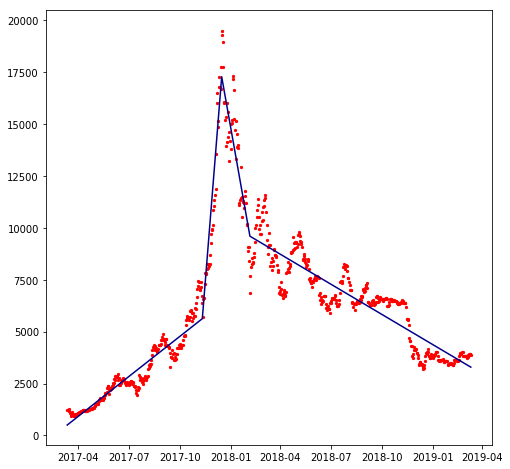

In [7]:
tau = [244, 279, 330]

xphi = PieceLinearSpline(x, tau)
xnew = sm.add_constant(xphi)
model = sm.OLS(y, xnew).fit()
yhat = model.predict(xnew)
print("SSE = ", np.round(model.centered_tss - model.ess,4))
print("R-Squared = ", np.round(model.rsquared,4))
print("F-Statistic = ", np.round(model.fvalue,4))

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(dt, yhat, "darkblue")
ax.scatter(dt, y, color='red',s=5)
ax.format_xdata = mdates.DateFormatter('%Y-%m')

## Step 5. Regression with Piecewise Linear Splines (Detection of Knots)

In [8]:
tau0 = []
lb, ub = 2, y.shape[0]-2
nk = 5
for j in range(nk):
    sse = np.zeros(len(range(lb,ub)))
    for k in range(lb,ub):
        if len(tau0) == 0:
            tau = [k]
        else:
            tau = [tau0[i] for i in range(len(tau0))]
            tau.append(k)
        xphi = PieceLinearSpline(x, tau)
        xnew = sm.add_constant(xphi)
        model = sm.OLS(y, xnew).fit()
        yhat = model.predict(xnew)
        sse[k-lb] = model.centered_tss - model.ess
    min_indx, min_val = np.argmin(sse)+lb, np.min(sse)
    tau0.append(min_indx)
    tau0.sort()

In [9]:
print("Selected knots:", tau0)

Selected knots: [198, 296, 382, 571, 648]


SSE =  916683046.721
R-Squared =  0.8989
F-Statistic =  1071.6976


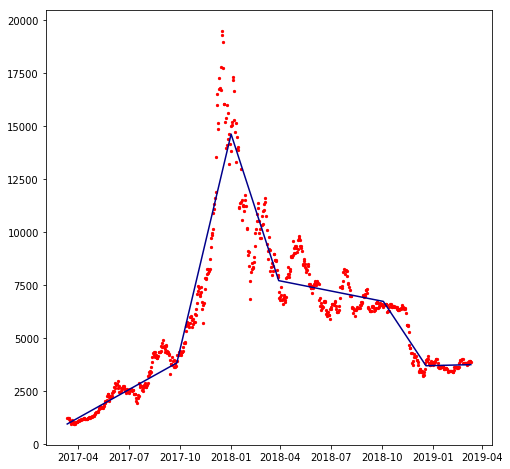

In [10]:
xphi = PieceLinearSpline(x, tau0)
xnew = sm.add_constant(xphi)
model = sm.OLS(y, xnew).fit()
yhat = model.predict(xnew)
print("SSE = ", np.round(model.centered_tss - model.ess,4))
print("R-Squared = ", np.round(model.rsquared,4))
print("F-Statistic = ", np.round(model.fvalue,4))

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(dt, yhat, "darkblue")
ax.scatter(dt, y, color='red',s=5)
ax.format_xdata = mdates.DateFormatter('%Y-%m')